# Recurrent Neural Networks

In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from d2l import torch as d2l
%matplotlib inline

In [2]:
import collections
import random
import re
import torch

## 9.1 Working with Sequences

In [2]:
T = 1000
tau = 5

In [3]:
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.randn(T) * 0.2

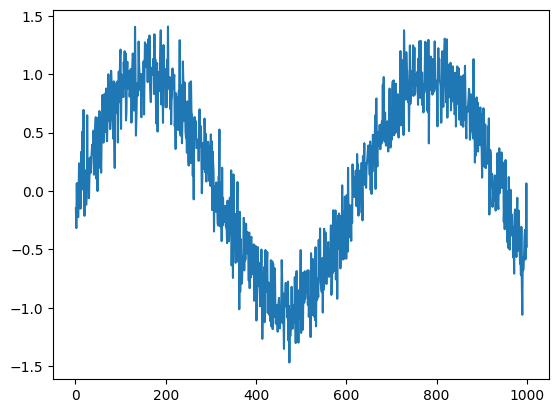

In [4]:
plt.plot(time, x)

In [5]:
features = [x[i : T-tau+i] for i in range(tau)]
features = torch.stack(features, 1)

features.shape

torch.Size([995, 5])

In [6]:
labels = x[tau:].unsqueeze(1)
labels.shape

torch.Size([995, 1])

In [7]:
features[:3], labels[:3]

(tensor([[-0.1459, -0.3175,  0.0662, -0.2109,  0.0655],
         [-0.3175,  0.0662, -0.2109,  0.0655, -0.2237],
         [ 0.0662, -0.2109,  0.0655, -0.2237, -0.0531]]),
 tensor([[-0.2237],
         [-0.0531],
         [ 0.2369]]))

In [8]:
train_slice = slice(0, 600)
test_slice = slice(600, None)
train_features = features[train_slice]
train_labels = labels[train_slice]
test_features = features[test_slice]
test_labels = labels[test_slice]

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, X):
        y = self.linear(X)
        return y

In [10]:
model = LinearRegression(tau)
model.parameters

<bound method Module.parameters of LinearRegression(
  (linear): Linear(in_features=5, out_features=1, bias=True)
)>

In [11]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [12]:
for epoch in range(100):
    result = model(train_features)
    l = loss(result, train_labels)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 1.052157
epoch 2, loss 0.954560
epoch 3, loss 0.866727
epoch 4, loss 0.787679
epoch 5, loss 0.716535
epoch 6, loss 0.652502
epoch 7, loss 0.594868
epoch 8, loss 0.542990
epoch 9, loss 0.496292
epoch 10, loss 0.454254
epoch 11, loss 0.416410
epoch 12, loss 0.382340
epoch 13, loss 0.351664
epoch 14, loss 0.324044
epoch 15, loss 0.299174
epoch 16, loss 0.276777
epoch 17, loss 0.256607
epoch 18, loss 0.238440
epoch 19, loss 0.222076
epoch 20, loss 0.207335
epoch 21, loss 0.194054
epoch 22, loss 0.182088
epoch 23, loss 0.171304
epoch 24, loss 0.161586
epoch 25, loss 0.152826
epoch 26, loss 0.144929
epoch 27, loss 0.137808
epoch 28, loss 0.131387
epoch 29, loss 0.125595
epoch 30, loss 0.120370
epoch 31, loss 0.115655
epoch 32, loss 0.111399
epoch 33, loss 0.107558
epoch 34, loss 0.104089
epoch 35, loss 0.100955
epoch 36, loss 0.098124
epoch 37, loss 0.095565
epoch 38, loss 0.093252
epoch 39, loss 0.091159
epoch 40, loss 0.089265
epoch 41, loss 0.087551
epoch 42, loss 0.085999
e

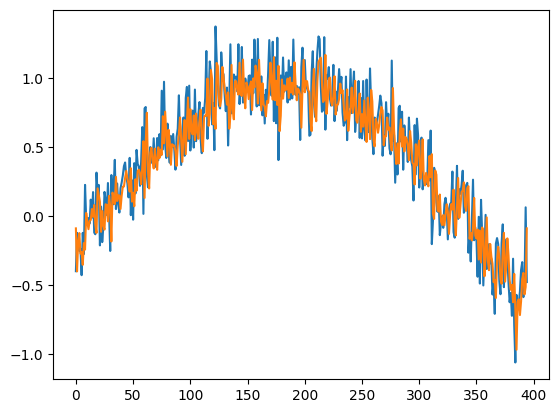

In [13]:
one_step_preds = model(test_features).detach().numpy()
plt.plot(test_labels.numpy(), label='true')
plt.plot(one_step_preds, label='pred')

In [14]:
multistep = x[train_slice]

In [15]:
features_len = len(test_features)
for i in range(1, len(test_labels)+1):
    step_features = multistep[-tau:].unsqueeze(0)
    step_preds = model(step_features).detach().numpy()

    multistep = torch.cat((multistep, torch.tensor(step_preds).flatten()))


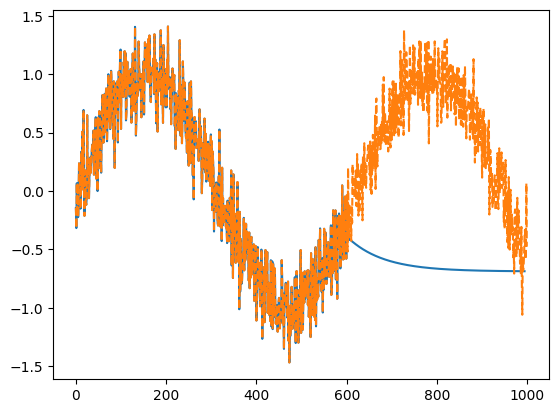

In [16]:
plt.plot(multistep.numpy(), label='pred')
plt.plot(x, label='true', linestyle='--')

## 9.2 Converting Raw Text into Sequence Data

In [18]:
def download_url(url, folder='data'):
    import os
    import requests
    if not os.path.exists(folder):
        os.makedirs(folder)
    fname = os.path.join(folder, url.split('/')[-1])
    if not os.path.isfile(fname):
        r = requests.get(url)
        with open(fname, 'wb') as f:
            f.write(r.content)
    return fname

In [19]:
URL = 'https://www.gutenberg.org/cache/epub/35/pg35.txt'
book = download_url(URL)
with open(book, 'r', encoding='utf-8') as f:
    raw_text = f.read()

In [1]:
def download_book():
    URL = 'https://www.gutenberg.org/cache/epub/35/pg35.txt'
    book = download_url(URL)
    with open(book, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text

In [20]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z]+', ' ', text)
    return text

In [21]:
text = preprocess(raw_text)

In [22]:
text

' the project gutenberg ebook of the time machine this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at www gutenberg org if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook title the time machine author h g wells release date october ebook most recently updated march language english start of the project gutenberg ebook the time machine the time machine an invention by h g wells contents i introduction ii the machine iii the time traveller returns iv time travelling v in the golden age vi the sunset of mankind vii a sudden shock viii explanation ix the morlocks x when night came xi the palace of green porcelain xii in the darkness xiii the trap of the white sphinx xiv the furt

In [23]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [24]:
tokens = list(text)
vocab = Vocab(tokens)

In [25]:
vocab[tokens[:10]], tokens[:10]

([0, 21, 9, 6, 0, 17, 19, 16, 11, 6],
 [' ', 't', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e'])

In [26]:
words = text.split()
vocab = Vocab(words)

vocab.token_freqs[:10], vocab.token_freqs[-10:]

([('the', 2477),
  ('and', 1311),
  ('of', 1285),
  ('i', 1268),
  ('a', 877),
  ('to', 766),
  ('in', 605),
  ('was', 554),
  ('that', 458),
  ('it', 452)],
 [('hart', 1),
  ('originator', 1),
  ('network', 1),
  ('volunteer', 1),
  ('pg', 1),
  ('facility', 1),
  ('includes', 1),
  ('produce', 1),
  ('subscribe', 1),
  ('newsletter', 1)])

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

In [4]:
x = d2l.TimeMachine(64, 10, 10000, 5000)

## 9.4 Recurrent Neural Networks

In [3]:
X, W_xh = torch.rand(3, 2), torch.rand(2, 5)
H, W_hh = torch.rand(3, 5), torch.rand(5, 5)

In [4]:
torch.mm(X, W_xh) + torch.mm(H, W_hh)

tensor([[1.1187, 1.4392, 0.5067, 2.2099, 1.9228],
        [0.5806, 1.1206, 0.3492, 1.8472, 1.5857],
        [0.8706, 1.0949, 0.4064, 1.5955, 1.8916]])

In [11]:
torch.mm(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[1.1187, 1.4392, 0.5067, 2.2099, 1.9228],
        [0.5806, 1.1206, 0.3492, 1.8472, 1.5857],
        [0.8706, 1.0949, 0.4064, 1.5955, 1.8916]])